Steps:
1. Fetch throwing game history for one team
2. compute selection and surface probability for each type of throws

## 1. Get throws outcome for one game using audl API

In [120]:
import audl
from audl.stats.endpoints.gamestats import GameStats

import math
import pandas as pd
import numpy as np
import scipy

In [2]:
GAME_ID = "2023-08-26-SLC-NY"
game = GameStats(GAME_ID)

In [6]:
df = game.get_throws_dataframe()

check error


In [7]:
df

,game_id,point,thrower_id,receiver_id,throw_type,throw_side,throw_distance,x,y,x_field,y_field,angle_degrees,thrower_ext_id,receiver_ext_id,thrower_full_name,receiver_full_name,team_ext_id
0,2023-08-26-SLC-NY,1,10882,10859,dump,left,12.218,10.23,-6.68,-16.10,43.77,-33.141227,jlithio,rosgar,None,None,empire
1,2023-08-26-SLC-NY,1,10859,10866,dump,left,8.930,6.55,-6.07,-9.55,37.70,-42.817452,rosgar,echartock,None,None,empire
2,2023-08-26-SLC-NY,1,10866,10859,swing,left,16.931,16.57,-3.48,7.02,34.22,-11.860077,echartock,rosgar,None,None,empire
3,2023-08-26-SLC-NY,1,10859,10862,pass,right,13.201,7.02,11.18,14.04,45.40,57.871326,rosgar,bjagt,None,None,empire
4,2023-08-26-SLC-NY,1,10862,10863,pass,right,9.447,2.87,9.00,16.91,54.40,72.307317,bjagt,cweinberg,None,None,empire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2023-08-26-SLC-NY,33,11412,11414,pass,right,12.595,9.03,8.78,-3.00,93.03,44.192618,cyorgason,wselfridg,None,None,shred
195,2023-08-26-SLC-NY,33,11414,11429,dish,right,15.746,15.73,0.71,12.73,93.74,2.584223,wselfridg,tmounga,None,None,shred
196,2023-08-26-SLC-NY,33,11429,<NA>,Throwaway,None,24.147,-15.80,18.26,-3.07,112.00,-49.132837,tmounga,None,None,None,shred
197,2023-08-26-SLC-NY,33,11429,11412,pass,left,17.160,-0.12,17.16,-20.67,93.61,-89.602675,tmounga,cyorgason,None,None,shred


## 2. For each throw type and side pair, compute surface and selection probability

In [10]:
from audl.stats.static.utils import get_throw_type

In [54]:
def get_clean_throw_df(df: pd.DataFrame):
    """
    """
    # split df into valid throws and throwaways
    valid_throws_types = ['dump', 'swing', 'dish', 'huck', 'pass']
    df_valid_throws = df[df['throw_type'].isin(valid_throws_types)]
    df_valid_throws.loc[:, 'successful'] = True

    df_throwaways = df[df['throw_type'] == 'Throwaway']
    df_throwaways.loc[:, 'throw_type'] = df_throwaways.apply(lambda r: get_throw_type(x1=0, y1=0, x2=r['x'], y2=r['y'])[0], axis=1)
    df_throwaways.loc[:, 'throw_side'] = df_throwaways.apply(lambda r: get_throw_type(x1=0, y1=0, x2=r['x'], y2=r['y'])[1], axis=1)
    df_throwaways.loc[:, 'successful'] = False

    # concatenate back
    df = pd.concat([df_valid_throws, df_throwaways]).reset_index(drop=True)
    return df

df_clean = get_clean_throw_df(df)

/home/yukikongju/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/yukikongju/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [55]:
df_clean

,game_id,point,thrower_id,receiver_id,throw_type,throw_side,throw_distance,x,y,x_field,y_field,angle_degrees,thrower_ext_id,receiver_ext_id,thrower_full_name,receiver_full_name,team_ext_id,successful
0,2023-08-26-SLC-NY,1,10882,10859,dump,left,12.218,10.23,-6.68,-16.10,43.77,-33.141227,jlithio,rosgar,None,None,empire,True
1,2023-08-26-SLC-NY,1,10859,10866,dump,left,8.930,6.55,-6.07,-9.55,37.70,-42.817452,rosgar,echartock,None,None,empire,True
2,2023-08-26-SLC-NY,1,10866,10859,swing,left,16.931,16.57,-3.48,7.02,34.22,-11.860077,echartock,rosgar,None,None,empire,True
3,2023-08-26-SLC-NY,1,10859,10862,pass,right,13.201,7.02,11.18,14.04,45.40,57.871326,rosgar,bjagt,None,None,empire,True
4,2023-08-26-SLC-NY,1,10862,10863,pass,right,9.447,2.87,9.00,16.91,54.40,72.307317,bjagt,cweinberg,None,None,empire,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2023-08-26-SLC-NY,28,11408,<NA>,pass,right,13.654,0.96,13.62,16.79,55.29,85.964013,lyorgason,None,None,None,shred,False
458,2023-08-26-SLC-NY,29,11648,<NA>,pass,left,34.305,-9.23,33.04,-26.03,78.58,-74.393459,jclutton,None,None,None,shred,False
459,2023-08-26-SLC-NY,31,11434,<NA>,huck,left,51.860,-29.79,42.45,-6.42,101.09,-54.941001,kweinberg,None,None,None,shred,False
460,2023-08-26-SLC-NY,32,11408,<NA>,pass,right,19.506,9.74,16.90,7.51,109.48,60.041259,lyorgason,None,None,None,shred,False


In [173]:
# calculate total successful throws per team
df_throws_counts = df_clean.groupby(['team_ext_id']).agg({'successful': ['sum', 'size']}).reset_index()
df_throws_counts = df_throws_counts.rename(columns={'successful': 'total'})

# calculate overall selection probability
df_selection = df_clean.groupby(['team_ext_id', 'throw_type']).agg({'successful': ['sum', 'size']}).reset_index()

df_selection = df_selection.merge(df_throws_counts, on=['team_ext_id'])
df_selection['completion_rate'] = df_selection['successful']['sum'] / df_selection['successful']['size']
df_selection['selection_rate'] = df_selection['successful']['size'] / df_selection['total']['size']

df_selection

team_ext_id throw_type successful      total      completion_rate  \
                                sum size   sum size                   
0      empire       dish         30   30   262  276        1.000000   
1      empire       dump         67   68   262  276        0.985294   
2      empire       huck          2    6   262  276        0.333333   
3      empire       pass        136  145   262  276        0.937931   
4      empire      swing         27   27   262  276        1.000000   
5       shred       dish         25   25   169  186        1.000000   
6       shred       dump         18   18   169  186        1.000000   
7       shred       huck          3    6   169  186        0.500000   
8       shred       pass        106  120   169  186        0.883333   
9       shred      swing         17   17   169  186        1.000000   

  selection_rate  
                  
0       0.108696  
1       0.246377  
2       0.021739  
3       0.525362  
4       0.097826  
5       0.134409  
6       0.096774  
7       0.032258  
8       0.645161  
9       0.091398

In [96]:
# calculate surface probability success
# completion_rate: 
# seletion_rate:
# overall_selection_rate:
df_surface = df_clean.groupby(['team_ext_id', 'throw_type', 'throw_side']).agg({'successful': ['sum', 'size']}).reset_index()

df_throws_type_counts = df_clean.groupby(['team_ext_id', 'throw_type']).agg({'successful': ['sum', 'size']}).reset_index()
df_throws_type_counts = df_throws_type_counts.rename(columns={'successful': 'total_type'})
df_surface = df_surface.merge(df_throws_type_counts, on=['team_ext_id', 'throw_type'])
df_surface = df_surface.merge(df_throws_counts, on=['team_ext_id'])

df_surface['completion_rate'] = df_surface['successful']['sum'] / df_surface['successful']['size']
df_surface['selection_type'] = df_surface['successful']['size'] / df_surface['total_type']['size']

df_surface['selection_rate'] = df_surface['successful']['size'] / df_surface['total']['size']


df_surface

team_ext_id throw_type throw_side successful      total_type      total  \
                                            sum size        sum size   sum   
0       empire       dish       left         14   14         30   30   262   
1       empire       dish      right         16   16         30   30   262   
2       empire       dump       left         31   32         67   68   262   
3       empire       dump      right         36   36         67   68   262   
4       empire       huck       left          2    5          2    6   262   
5       empire       huck      right          0    1          2    6   262   
6       empire       pass       left         61   65        136  145   262   
7       empire       pass      right         75   80        136  145   262   
8       empire      swing       left         13   13         27   27   262   
9       empire      swing      right         14   14         27   27   262   
10       shred       dish       left         12   12         25   25   169   
11       shred       dish      right         13   13         25   25   169   
12       shred       dump       left          8    8         18   18   169   
13       shred       dump      right         10   10         18   18   169   
14       shred       huck       left          2    5          3    6   169   
15       shred       huck      right          1    1          3    6   169   
16       shred       pass       left         58   69        106  120   169   
17       shred       pass      right         48   51        106  120   169   
18       shred      swing       left          7    7         17   17   169   
19       shred      swing      right         10   10         17   17   169   

        completion_rate selection_type selection_rate  
   size                                                
0   276        1.000000       0.466667       0.050725  
1   276        1.000000       0.533333       0.057971  
2   276        0.968750       0.470588       0.115942  
3   276        1.000000       0.529412       0.130435  
4   276        0.400000       0.833333       0.018116  
5   276        0.000000       0.166667       0.003623  
6   276        0.938462       0.448276       0.235507  
7   276        0.937500       0.551724       0.289855  
8   276        1.000000       0.481481       0.047101  
9   276        1.000000       0.518519       0.050725  
10  186        1.000000       0.480000       0.064516  
11  186        1.000000       0.520000       0.069892  
12  186        1.000000       0.444444       0.043011  
13  186        1.000000       0.555556       0.053763  
14  186        0.400000       0.833333       0.026882  
15  186        1.000000       0.166667       0.005376  
16  186        0.840580       0.575000       0.370968  
17  186        0.941176       0.425000       0.274194  
18  186        1.000000       0.411765       0.037634  
19  186        1.000000       0.588235       0.053763

In [49]:
# df_clean[(df_clean['team_ext_id'] == 'shred') & (df_clean['throw_type'] == 'pass') & (df_clean['throw_side'] == 'left')]

In [58]:
# df_clean[(df_clean['team_ext_id'] == 'empire') & (df_clean['throw_type'] == 'pass')]

In [59]:
# df[(df['team_ext_id'] == 'empire') & (df['throw_type'] == 'pass')]

## 2. Visualize success proba for each throw relative to field position 

In [101]:
import matplotlib.pyplot as plt

In [99]:
print(df_clean['x_field'].min())
print(df_clean['x_field'].max())
print(df_clean['y_field'].min())
print(df_clean['y_field'].max())

-26.03
25.64
5.79
116.04


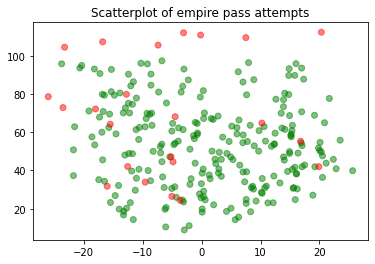

In [118]:
def plot_team_throw_scatterplot(team_ext_id: str, throw_type: str):
    is_throw_type = df_clean['throw_type'] == throw_type
    is_team = df_clean['team_ext_id'] == team_ext_id
    df_pass = df_clean[is_team & is_throw_type]
    
    df_pass = df_clean[df_clean['throw_type'] == 'pass']
    colors = df_pass['successful'].map({True: 'green', False: 'red'})
    plt.scatter(x=df_pass['x_field'], y=df_pass['y_field'], c=colors, alpha=0.5)
    plt.title(f"Scatterplot of {team_ext_id} {throw_type} attempts")
    plt.show()

plot_team_throw_scatterplot(team_ext_id='empire', throw_type='pass')

In [171]:
class TeamGameInfo:

    """
    Class which compute a team's throwing decisions based on a given game
    """

    def __init__(self, game_id: str, team_ext_id: str):
        """
        
        Parameters
        ----------
        
        """
        self.game_id = game_id
        self.team_ext_id = team_ext_id

    def _get_throws():
        

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0475
0.04750000000000001
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.047500000000000014
0.09
0.09
0.09
0.09
0.09
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275
0.1275


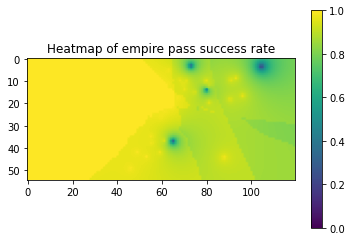

In [175]:
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KNeighborsRegressor



def euclidean_distance(p1: np.array, p2: np.array):
    return np.sqrt(np.sum((p1 - p2)**2))

                   
def plot_team_throw_heatmap(team_ext_id: str, throw_type: str, throw_side: str):
    OFFSET_WIDTH = 27
    FIELD_WIDTH, FIELD_LENGTH = 55, 120
    NUM_NEIGHBORS = 20
    
    field = np.zeros([55, 120])

    # filter out rows
    is_throw_type = df_clean['throw_type'] == throw_type
    is_team = df_clean['team_ext_id'] == team_ext_id
    is_throw_side = df_clean['throw_side'] == throw_side
    df = df_clean[is_team & is_throw_type & is_throw_side]

    points = np.array(df[['x_field', 'y_field']])
    successes = np.array(df[['successful']])
    x_deltas, y_deltas = np.array(df[['x']]), np.array(df[['y']])

    # --- compute probability weighted by distance using KNN => FIXME
    knn_proba = KNeighborsRegressor(n_neighbors = NUM_NEIGHBORS, weights = 'distance', algorithm='auto', metric='minkowski')
    knn_proba.fit(points, successes)
    
    knn_x = KNeighborsRegressor(n_neighbors = NUM_NEIGHBORS, weights = 'distance', algorithm='auto', metric='minkowski')
    knn_x.fit(points, x_deltas)

    knn_y = KNeighborsRegressor(n_neighbors = NUM_NEIGHBORS, weights = 'distance', algorithm='auto', metric='minkowski')
    knn_y.fit(points, y_deltas)

    for x_pos in range(FIELD_WIDTH):
        for y_pos in range(FIELD_LENGTH):
            # compute distances from each points
            current_pos = np.array([x_pos-OFFSET_WIDTH, y_pos])
            proba_mean  = knn_proba.predict([current_pos])
            distances, indices = knn_proba.kneighbors([current_pos])
            neighbors_probas = successes[indices]
            
            proba_var = np.var(neighbors_probas)
            field[x_pos][y_pos] = proba_mean
    # print(field)

    # --- plot heatmap
    plt.imshow(field, cmap='viridis', vmin=0, vmax=1)
    plt.title(f"Heatmap of {team_ext_id} {throw_type} success rate")
    plt.colorbar()
    plt.show()


plot_team_throw_heatmap(team_ext_id='empire', throw_type='pass', throw_side='left')

In [132]:
# --- compute pass probability for each type of throws-side pair 

array([-16.1 ,  43.77])

## 3. Compute Information to initialize UltimateFrisbee Environment

Things to have for Ultimate Environment:
- for each field position-pass-side tuple: [EXPLOITATION]
    - what's the probability of completion
    - what's the throws: (1) mean distance, (2) mean angle
- for each field position: [EXPLORATION]
    - what's the distribution of throws ie what throw are team throwing



In [177]:
throws_types = ['dump', 'swing', 'dish', 'huck', 'pass']
throws_sides = ['left', 'right']

import itertools
list(itertools.product(throws_types, throws_sides))

[('dump', 'left'),
 ('dump', 'right'),
 ('swing', 'left'),
 ('swing', 'right'),
 ('dish', 'left'),
 ('dish', 'right'),
 ('huck', 'left'),
 ('huck', 'right'),
 ('pass', 'left'),
 ('pass', 'right')]